# Data Mining Materials with pymatgen and matminer

Materials science is entering the data-driven era. With the rise of high-throughput density functional theory (DFT) calculations, massive datasets containing structural, electronic, and thermodynamic properties of materials are now publicly available. However, having big data is not enough — we need tools to:

1. Access this data programmatically.
2. Process, clean, and organize the data.
3. Extract useful features ("descriptors") that represent material properties.
4. Use these features for machine learning models and materials discovery.

In this tutorial, we will go beyond simple querying and learn how to search for new semiconducting materials that are similar to a known compound.

We will start from the material that has been used in previous tutorials, $\text{CaTiO}_3$, a perovskite oxide, and follow this process:

1. Choose a neighboring transition metal to substitute for Ti — we will take V.

2. Use band gap constraints to ensure the candidates are semiconductors.

3. Search for materials with similar composition using:

    - Pymatgen + Materials Project

    - Matminer datasets

4. Compare results and discuss possible applications.

---
## Step 1 - Setup and Installation

First, make sure you have the required libraries installed:

In [1]:
import pandas as pd # to organize data
import matplotlib.pyplot as plt 
import seaborn as sns # to visualize patterns and highlights 

from mp_api.client import MPRester
from matminer.datasets import load_dataset

/home/paladin/anaconda3/envs/matdata/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Step 2 - Defining the Search Parameters

Our base compound is $\text{CaTiO}_3$. Suppose we are investigating its properties because it shows promise for a specific application — say, as a **semiconducting material** for solar energy harvesting.

However, we might run into a few real-world constraints:

- Availability: Titanium may not be easily accessible or cost-effective in some regions.

- Performance: There might exist similar compounds with better electronic properties.

- Exploration: Sometimes, materials science is about looking for nearby alternatives that can surprise us.

To start our exploration, we’ll use a data-driven approach by querying the Materials Project database.

### Choosing a Neighboring Transition Metal

Looking at the Periodic Table, we notice that vanadium (V) sits right next to titanium (Ti) in the transition metals block.
Neighboring elements often share similar electronic configurations, so replacing Ti with V in $\text{CaTiO}_3$ could lead to structurally similar compounds — but with potentially different band gaps and properties.

Therefore, our new chemical system of interest is:

Calcium-Vanadium-Oxygen (Ca–V–O)

### Focusing on Semiconductors

Since we want to explore semiconductors for applications like photovoltaics, LEDs, or sensors, we’ll limit our search to materials with a band gap between $1.1$ and $3.2 \text{eV}$

This range covers typical semiconductors, excluding metals (small/no band gap) and insulators (very large band gap).

In summary, our search parameters are:

- Base compound: CaTiO₃

- Neighboring transition metal: V (Titanium neighbor).

- Band gap range: 1.1 – 3.2 eV (we want semiconductors).

- Chemically similar systems: Calcium-Vanadium oxides (Ca-V-O).

---
## Step 3 - Querying the Materials Project

### Connecting to the Materials Project

Just as we did in the previous tutorial, we need to connect to the Materials Project to retrieve data by using our API key. For a detailed guide on how to obtain the key, please refer to the tutorial: [Querying Materials]((../querying/querying_materials.ipynb)).

```{important}
**Remember: you should not share your API key with anyone.**
```

We query the Materials Project database for Ca-V-O materials within the band gap range

In [ ]:
# Replace YOUR_API_KEY_HERE with your Materials Project API key
API_KEY = "YOUR_APIA_KEY_HERE"
mpr = MPRester(API_KEY)

# Search parameters
bandgap_min = 1.1
bandgap_max = 3.2
chemsys = "Ca-V-O"  # Searching for CaVO3 and similar oxides

In [3]:
# Query Materials Project for Ca-Zr-O semiconductors
results_mp = mpr.materials.summary.search(
    chemsys=chemsys,
    band_gap=(bandgap_min, bandgap_max),
    fields=["material_id", "formula_pretty", "band_gap",
            "formation_energy_per_atom", "density", "symmetry"]
)

df_mp = pd.DataFrame([
    {
        "material_id": r.material_id,
        "formula": r.formula_pretty,
        "band_gap": r.band_gap,
        "formation_energy_per_atom": r.formation_energy_per_atom,
        "density": r.density,
        "crystal_system": r.symmetry.crystal_system
    }
    for r in results_mp
])

# Sort by band gap for better readability
df_mp = df_mp.sort_values(by="band_gap").reset_index(drop=True)

df_mp

Retrieving SummaryDoc documents: 100%|██████████| 15/15 [00:00<00:00, 91846.07it/s]


,material_id,formula,band_gap,formation_energy_per_atom,density,crystal_system
0,mp-1048922,CaV2O4,1.1633,-2.709560,3.867841,Trigonal
1,mp-1041142,CaV2O4,1.2168,-2.736091,3.852460,Trigonal
2,mp-1365417,CaV2O4,1.3267,-2.684335,3.898550,Monoclinic
3,mp-1284741,Ca2V3O8,1.4963,-2.862569,3.822025,Monoclinic
4,mp-1342904,CaV2O6,1.5352,-2.567944,3.616555,Orthorhombic
5,mp-1835930,CaV2O4,1.5513,-2.788971,4.098466,Monoclinic
6,mp-1042856,Ca2V3O8,1.6592,-2.765350,3.571802,Hexagonal
7,mp-1663141,Ca2V3O8,1.9017,-2.777982,3.562255,Hexagonal
8,mp-1043217,CaV2O5,2.1831,-2.758699,3.054736,Orthorhombic
9,mp-891955,Ca10V6O25,2.3146,-2.990032,3.102293,Trigonal


---
## Step 4 - Exploring the Results

After retrieving our dataset from the Materials Project, the next step is to explore it visually. Tables of numbers are useful, but they can be overwhelming — plots often reveal patterns and insights much more quickly.

### Histogram: distribution of band gaps

One property we are especially interested in is the band gap, since it determines whether a material behaves as a conductor, semiconductor, or insulator. Recall that we set our search range to 1.1–3.2 eV because we are specifically targeting semiconductors.

To better understand how the band gaps of our retrieved materials are distributed, let’s make a histogram. This plot will show us how many of the Ca–V–O compounds fall into different band gap ranges.

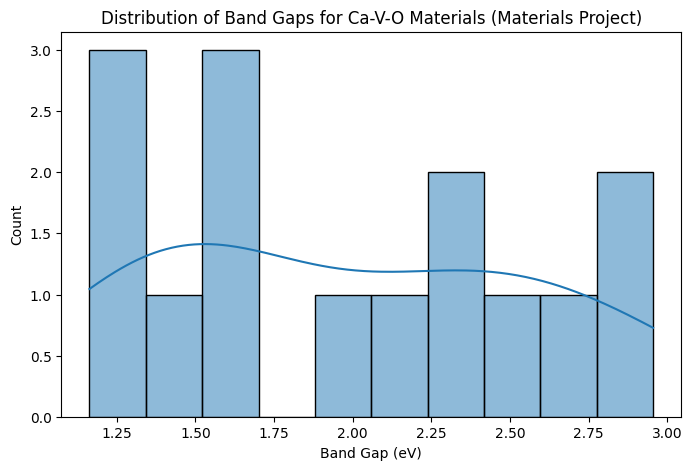

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df_mp["band_gap"], bins=10, kde=True)
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of Band Gaps for Ca-V-O Materials (Materials Project)")
plt.show()

The histogram gives us a distribution of band gaps for all the candidate materials in our search. Each bar represents the number of materials with a band gap in a certain range, and the smooth line (kernel density estimate) helps us see the overall shape of the distribution.

By inspecting this plot, we can quickly answer questions such as:

- Do most of the Ca–V–O compounds cluster around a narrow band gap range, or are they spread out?

- Are there enough candidates with band gaps close to the ideal semiconductor values (e.g., ~1.5–2.0 eV for solar cell applications)?

- Are there any outliers with unusually high or low band gaps compared to the rest?

This kind of exploratory visualization helps us narrow down which materials may be most promising for further study, without having to examine each entry individually.

### Scatter Plot: Band Gap vs. Formation Energy

Formation energy per atom tells us how stable a material is — lower (more negative) values generally mean more stable compounds. Plotting formation energy against band gap helps us identify candidates that are both stable and in the desired band gap range.

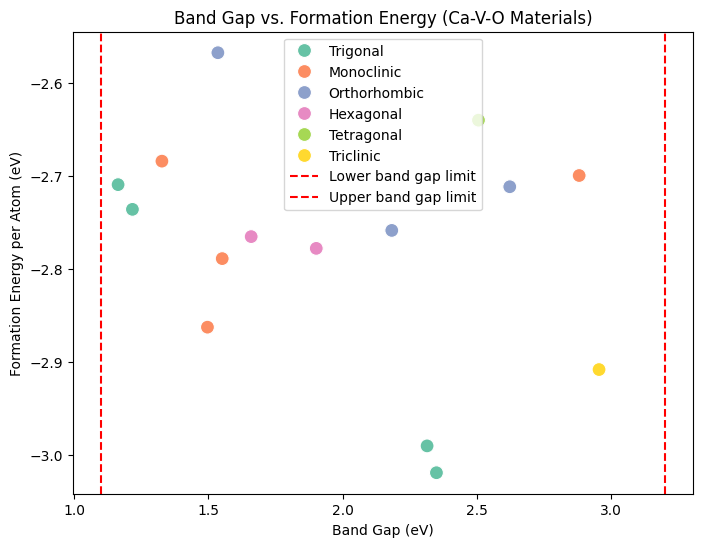

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_mp,
    x="band_gap", 
    y="formation_energy_per_atom",
    hue="crystal_system",
    s=100,
    palette="Set2"
)
plt.axvline(1.1, color="red", linestyle="--", label="Lower band gap limit")
plt.axvline(3.2, color="red", linestyle="--", label="Upper band gap limit")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Formation Energy per Atom (eV)")
plt.title("Band Gap vs. Formation Energy (Ca-V-O Materials)")
plt.legend()
plt.show()


```{tip}
- Points further down (more negative formation energy) represent more stable compounds.

- The vertical dashed lines mark our chosen semiconductor band gap window.

- By looking at the points within this window, we can spot which candidates are both semiconducting and stable, making them more attractive for real applications.
```

### Density Distribution by Crystal System

Another interesting angle is to check if different crystal systems tend to have different densities. This can be useful for practical applications, where density affects properties like mass transport, mechanical strength, and cost.

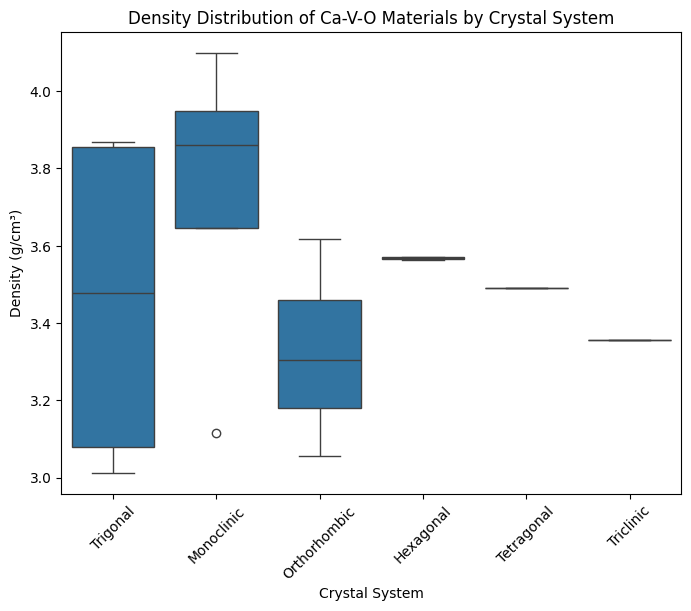

In [6]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_mp, 
    x="crystal_system", 
    y="density"
)
plt.xlabel("Crystal System")
plt.ylabel("Density (g/cm³)")
plt.title("Density Distribution of Ca-V-O Materials by Crystal System")
plt.xticks(rotation=45)
plt.show()


```{tip}
- Each box summarizes the density distribution for a given crystal system.

- This allows us to see whether certain crystal families (e.g., monoclinic vs. orthorhombic) tend to be lighter or denser.

- If a specific application (say, lightweight materials for aerospace) requires low density, this view can guide which crystal systems deserve more attention.
```

---
## Step 5 - Using Matminer Datasets

The matminer library provides curated datasets ready for materials informatics. If you want to learn more about the datasets available in matminer, you can visit [their website here](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html). It is a very complete page that indicates the names and the content of the datasets, in addition to the number of entries of each dataset. This information will be essential when choosing which dataset might be useful for our wanted criteria. In our example, we are working with perovskites and a limited bandgap, so we will load matminer datasets that contain this information.

We can also check the list using code, as follows:

In [7]:
from matminer.datasets import get_available_datasets

# List all datasets available
datasets = get_available_datasets()
print(datasets)


boltztrap_mp: Effective mass and thermoelectric properties of 8924 compounds in The  Materials Project database that are calculated by the BoltzTraP software package run on the GGA-PBE or GGA+U density functional theory calculation results. The properties are reported at the temperature of 300 Kelvin and the carrier concentration of 1e18 1/cm3.

brgoch_superhard_training: 2574 materials used for training regressors that predict shear and bulk modulus.

castelli_perovskites: 18,928 perovskites generated with ABX combinatorics, calculating gllbsc band gap and pbe structure, and also reporting absolute band edge positions and heat of formation.

citrine_thermal_conductivity: Thermal conductivity of 872 compounds measured experimentally and retrieved from Citrine database from various references. The reported values are measured at various temperatures of which 295 are at room temperature.

dielectric_constant: 1,056 structures with dielectric properties, calculated with DFPT-PBE.

double_

Here, we can identify datasets that are relevant to our study. Some potentially useful ones are:

- castelli_perovskites
- double_perovskites_gap
- wolverton_oxides

### Loading a Dataset from Matminer

We start by importing and loading the three datasets that seemed most promising:

In [8]:
from matminer.datasets import load_dataset

# Candidate datasets
df_castelli = load_dataset("castelli_perovskites")
df_double = load_dataset("double_perovskites_gap")
df_wolverton = load_dataset("wolverton_oxides")

# Quick overview
print("Castelli Perovskites:", df_castelli.shape, df_castelli.columns)
print("Double Perovskites:", df_double.shape, df_double.columns)
print("Wolverton Oxides:", df_wolverton.shape, df_wolverton.columns)

Castelli Perovskites: (18928, 10) Index(['fermi level', 'fermi width', 'e_form', 'gap is direct', 'structure',
       'mu_b', 'formula', 'vbm', 'cbm', 'gap gllbsc'],
      dtype='object')
Double Perovskites: (1306, 6) Index(['formula', 'a_1', 'b_1', 'a_2', 'b_2', 'gap gllbsc'], dtype='object')
Wolverton Oxides: (4914, 16) Index(['formula', 'atom a', 'atom b', 'lowest distortion', 'e_form', 'e_hull',
       'mu_b', 'vpa', 'gap pbe', 'a', 'b', 'c', 'alpha', 'beta', 'gamma',
       'e_form oxygen'],
      dtype='object')


---
## Step 6 - Assessing Dataset Suitability

Not all datasets are equally useful for our specific purpose (analyzing band gaps). We will check their columns.
We see that the property that is relevant to us right now (band gap) appears in each of the datasets as a column. For `castellli_perovskites` and `double_perovskites_gap` the column is `gap gllbsc`. For `wolverton_oxides` it is `gap pbe`

In [9]:
print("Castelli band gap summary:")
print(df_castelli["gap gllbsc"].describe())

print("\nDouble Perovskites band gap summary:")
print(df_double["gap gllbsc"].describe())

print("\nWolverton Oxides band gap summary:")
print(df_wolverton["gap pbe"].describe())


Castelli band gap summary:
count    18928.000000
mean         0.070813
std          0.459684
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: gap gllbsc, dtype: float64

Double Perovskites band gap summary:
count    1306.000000
mean        4.012035
std         1.581775
min         0.106620
25%         2.786297
50%         4.074557
75%         5.090252
max         8.343255
Name: gap gllbsc, dtype: float64

Wolverton Oxides band gap summary:
count    4914.000000
mean        0.360123
std         0.902904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.221000
Name: gap pbe, dtype: float64


### Findings:

- **Castelli Perovskites**

    - The gap pbe column seems to be almost entirely zero.

    - This means it cannot be used to analyze band gaps.

    - Still useful for other properties, but not suitable for our current task.

- **Double Perovskites (gap dataset)**

    - Contains a valid gap pbe column.

    - Good candidate for band gap exploration.

- **Wolverton Oxides**

    - Also contains a column with mostly zero values.

```{important}
This evaluation step is crucial: before doing any analysis, we must ensure the dataset actually contains meaningful data for the property of interest.
```

For our assessment, we will continue with `double_perovskites_gap`.


In [10]:
df_double.head()

,formula,a_1,b_1,a_2,b_2,gap gllbsc
0,AgNbLaAlO6,Ag,Nb,La,Al,4.164543
1,AgNbLaGaO6,Ag,Nb,La,Ga,4.454629
2,AgNbLaInO6,Ag,Nb,La,In,4.192522
3,AgNbMgTiO6,Ag,Nb,Mg,Ti,3.963857
4,AgNbSnTiO6,Ag,Nb,Sn,Ti,2.881239


---
## Step 7 - Filtering the Dataset

Now that we have chosen a suitable dataset, we are going to filter out to narrow our results closer to what we are looking for:

- Restrict the bandgap range to semiconductors (1.1-3.2 eV).
- Filter by formula to focus on Ca-containing oxides, and then of those results, only the ones containing V.

In [11]:
# Apply band gap filter
gap_min, gap_max = 1.1, 3.2

df_double_filtered = df_double[(df_double["gap gllbsc"] >= gap_min) & 
                               (df_double["gap gllbsc"] <= gap_max)]

# Further filter: only Ca-containing compounds
df_double_filtered = df_double_filtered[df_double_filtered["formula"].str.contains("Ca", na=False)]
df_double_filtered = df_double_filtered[df_double_filtered["formula"].str.contains("V", na=False)]

print("Double Perovskites (filtered):", df_double_filtered.shape)


Double Perovskites (filtered): (17, 6)


We can see that the dataset got reduced from 1306 to 17 entries.

### Comparing Band Gap distributions

Once our datasets are filtered to a comparables scope (same band gap range, Ca-V based compounds), we can finally place them side by side. This will show us the differences using different data sources for our analysis:

- Materials project query: a targeted search we designed ourselves (Ca-V-O only). It reflects very specific chemistry and electronic criteria.

- Matminer datasets: pre-curated collections from the literature. Even after filtering, they reflect different sampling strategies and levels of completeness.

By comparing distributions, we can ask:

- Do the curated datasets reproduce trends similar to a direct query from the Materials Project?

- Are there systematic differences (e.g., broader or narrower band gap ranges)?

- How does dataset choice influence the materials we might consider for applications?

This is important because in real research, your conclusions may depend on the data source you rely on.

We use a **Kernel Density Estimate (KDE)** plot to overlay the band gap distributions. This smooth curve allows us to see not just raw counts, but the overall shape of the distribution for each dataset.

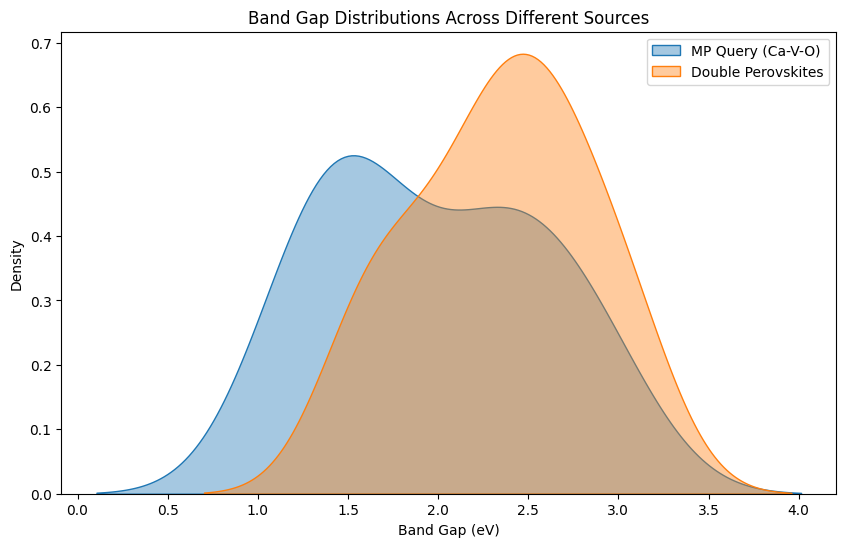

In [12]:
plt.figure(figsize=(10,6))

sns.kdeplot(df_mp["band_gap"], label="MP Query (Ca-V-O)", fill=True, alpha=0.4)
sns.kdeplot(df_double_filtered["gap gllbsc"], label="Double Perovskites", fill=True, alpha=0.4)

plt.xlabel("Band Gap (eV)")
plt.ylabel("Density")
plt.title("Band Gap Distributions Across Different Sources")
plt.legend()
plt.show()


```{tip}
Pay attention to:

- Peaks in the distributions: indicate “common” band gaps for the given chemistry and dataset.

- Shifts between datasets: can reveal methodological or sampling differences (e.g., if one dataset is consistently lower/higher).

- Spread of the curves: tells us whether a dataset captures a wide variety of materials or only a narrow subset.
```

---
## Step 8 - Reflecting on the Filtered Matminer Results

We would like to have an idea of the materials that we obtained from our filtering process with matminer too:

In [13]:
df_double_filtered

,formula,a_1,b_1,a_2,b_2,gap gllbsc
207,CaHfCsVO6,Ca,Hf,Cs,V,2.234428
219,CaHfLiVO6,Ca,Hf,Li,V,2.939416
225,CaHfNaVO6,Ca,Hf,Na,V,2.576283
275,CaZrCsVO6,Ca,Zr,Cs,V,2.604377
288,CaZrLiVO6,Ca,Zr,Li,V,3.120800
294,CaZrNaVO6,Ca,Zr,Na,V,2.457279
390,CsVCaGeO6,Cs,V,Ca,Ge,1.540581
392,CsVCaSnO6,Cs,V,Ca,Sn,1.797516
393,CsVCaTiO6,Cs,V,Ca,Ti,2.424147
750,LiVCaGeO6,Li,V,Ca,Ge,2.638234


After applying our filters (Ca + V + semiconductor band gap range), we obtained a set of candidate materials from the Matminer datasets. At first glance, their chemical formulas look different from the ones we retrieved directly from the Materials Project.

Why is that?

- Materials Project query gave us simple ternary oxides (Ca–V–O), as we explicitly defined the chemical system.

- Matminer datasets (like double_perovskites_gap) contain double perovskites, which are more complex by design. This means the filtered results include Ca, V, and O, but also additional elements.

So, while both datasets respect our filters, they represent different chemical spaces:

- Materials Project: minimal chemical system, narrow and well-controlled.

- Matminer: richer perovskite family, where our chosen elements coexist with others.

```{important}
- In data mining, it’s not just about *what* you filter, but also about *where* the data comes from.

- The MP results might be more directly comparable to our base compound (CaTiO₃).

- The Matminer results, however, open doors to more exploratory searches, where V is embedded in larger families of perovskite structures.
```

## Step 9 - Wrapping up

We have now completed our journey through a meaningful example of data mining in materials science. Let’s briefly reflect on the path we followed and what we learned along the way:

### What we did

- Defined a scientific question: exploring alternatives to CaTiO₃ by substituting Ti with V while keeping an eye on semiconducting behavior.

- Used the Materials Project: we learned how to query a live database with specific parameters (composition + band gap range), and explored the returned materials through organized dataframes and visualizations.

- Analyzed distributions: plots helped us quickly see trends in band gaps, densities, and crystal systems.

- Explored curated datasets with Matminer: we experimented with external datasets like double_perovskites_gap and wolverton_oxides, and discovered how dataset design shapes the results we obtain.

- Reflected on data sources: we learned that the same filter criteria can yield very different sets of candidate materials, depending on whether the dataset focuses on simple oxides, perovskites, or other families.

---

### Key takeaways

- Data mining is contextual: knowing your dataset is as important as knowing your filters.

- Visualization is powerful: simple plots can reveal trends and guide decisions.

- Different databases complement each other: Materials Project provides up-to-date calculations, while Matminer offers curated, task-specific datasets that enable broader explorations.

---

### Next steps

This tutorial provided only a first look at how materials data mining works. Here are some directions for further exploration:

- Try substituting other transition metals (e.g., Nb, Cr, Fe) and compare trends.

- Extend the workflow by adding stability checks (e.g., energy above hull from Materials Project).

- Apply machine learning tools from Matminer to predict band gaps or other properties.

- Connect this workflow with ASE to automatically build and manipulate structures for deeper analysis.